In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR
using Nevanlinna

In [2]:
T = BigFloat

BigFloat

In [3]:
beta::Float64 = 100
wmax::Float64 = 100
basis = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 

FiniteTempBasisSet with β = 100.0, ωmax = 100.0

In [4]:
include("../flex_src/IRFLEX.jl")

Main.IRFLEX

In [5]:
nsize::Int64 = 2048
t_pra::Float64 = 0.0375
filling::Float64 = 1.0
U::Float64 = 0.1
function single_Hami(x::Float64, y::Float64, t::Float64, t_pra::Float64)::Float64
    e::Float64 = -2.0*t*(cos(x)+cos(y)) + 4.0*t_pra*cos(x)*cos(y)                   
end
hami::Function = (x,y) -> single_Hami(x,y,0.125,t_pra)
#U::Float64 = 0.6
#hami::Function = (x,y) -> IRFLEX.single_Hami(x,y,t_pra)
lat = IRFLEX.SingleLatticeModel(nsize, filling, U, SparseIR.β(basis), hami)
;

In [6]:
ratio_U = 0.0
precision = 1e-4
loose_precision = 1e+3*precision
gkf0 = IRFLEX.make_free_giw(lat, basis)
;

In [7]:
# Compute chi0
chi0kf = IRFLEX.calc_chi0(gkf0, lat, basis)
;

In [8]:
# Compute chi
chiskf = chi0kf ./ (1.0 .- lat.U*chi0kf)
;

In [9]:
hnw = (length(basis.smpl_wn_b.sampling_points)-1)÷2

52

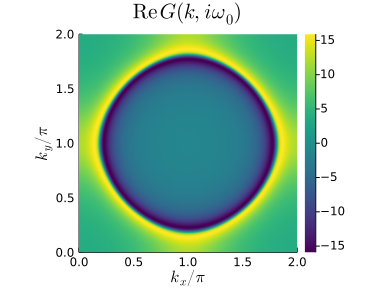

In [10]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(gkf0[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Re}\\,G(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

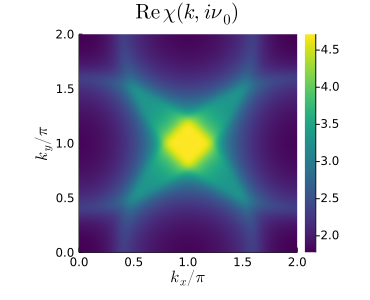

In [11]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(chiskf[hnw+1,:,:]),
    title=latexstring("\\mathrm{Re}\\,\\chi(k,i\\nu_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"),
    c=:viridis,
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [42]:
chiskf[hnw+1,nsize÷2+1, nsize÷2+1]

4.710806697240345 + 4.342684580097375e-15im

In [13]:
#smpl_wn_b = SparseIR.default_matsubara_sampling_points(basis.basis_b)
#smpl_wn_b = smpl_wn_b[smpl_wn_b .!= BosonicFreq(0)]
#smpl_wn_b_wo_zero = MatsubaraSampling(basis.basis_b, smpl_wn_b)
;

In [14]:
chisf = chi0kf[:,nsize÷2+1, nsize÷2+1]
#deleteat!(chisf, hnw+1)
#chisl = fit(smpl_wn_b_wo_zero, chisf, dim=1)
#chisf[37] = 0
chisl = fit(basis.smpl_wn_b, chisf, dim=1)
;

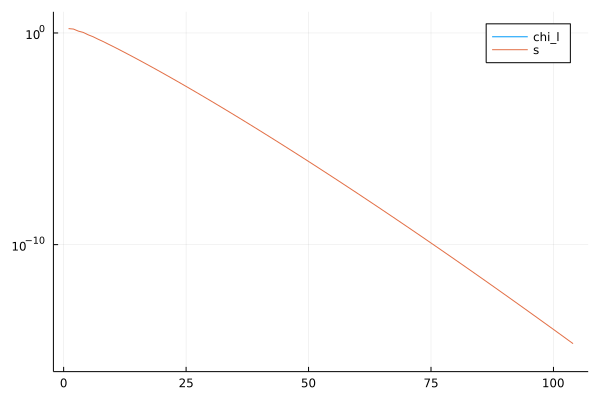

In [15]:
plot(yaxis=:log,ylims=(1e-16,10))
#plot()
plot!(real.(chisl),label="chi_l")
plot!(real.(basis.basis_b.s),label="s")

In [16]:
SparseIR.sampling_points(basis.smpl_wn_f)[1].n

-45241

In [17]:
sampling_points_dense = SparseIR.FermionicFreq.(collect(basis.wn_f[1].n:2:basis.wn_f[length(basis.wn_f)].n))
smpl_wn_f_dense = MatsubaraSampling(basis.basis_f, sampling_points_dense)
;

In [18]:
dense_hnw = length(sampling_points_dense) ÷ 2

22621

In [19]:
#smpl_wn_b_dense = MatsubaraSampling(basis.basis_b, SparseIR.BosonicFreq.(collect(-2332:2:2332)))
#chisl_d = fit(basis.smpl_wn_b, chisf)
#chisf_d = evaluate(smpl_wn_b_dense, chisl_d)
#deleteat!(chisf_d, 1167)
#chisf_d[1167]=0.0
#chisl_d = fit(smpl_wn_b_dense, chisf_d)
;

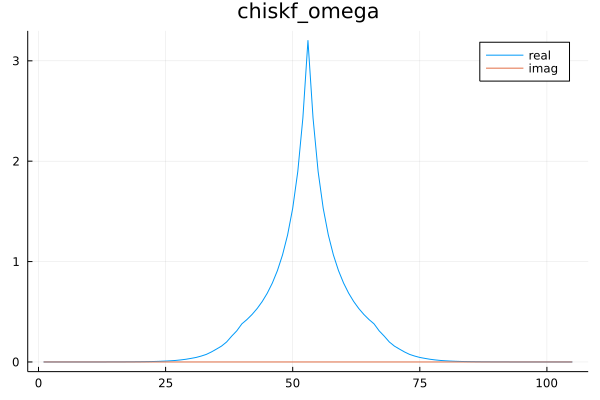

In [20]:
plot(title="chiskf_omega")
plot!(real.(chisf), label="real")
plot!(imag.(chisf), label="imag")

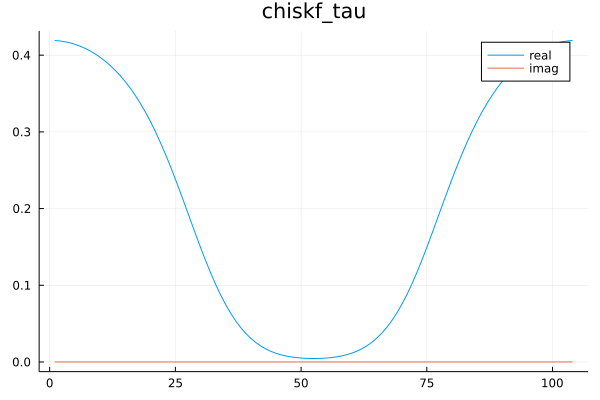

In [21]:
chist = evaluate(basis.smpl_tau_b, chisl)
plot(title="chiskf_tau")
plot!(real.(chist[:]), label="real")
plot!(imag.(chist[:]), label="imag")

In [22]:
#chisw = evaluate(basis.smpl_wn_f, chisl)
chisw = evaluate(smpl_wn_f_dense, chisl)
;

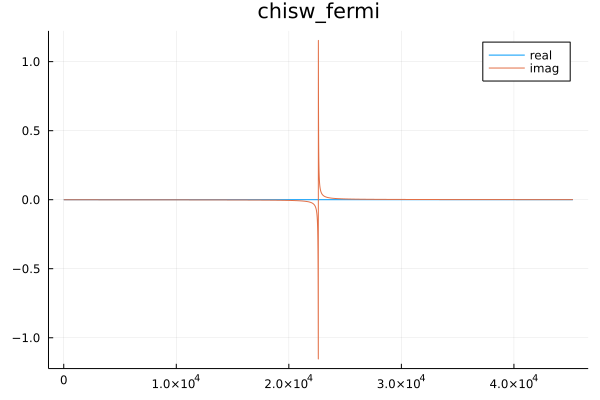

In [23]:
plot(title="chisw_fermi")
plot!(real.(chisw[:]), label="real")
plot!(imag.(chisw[:]), label="imag")

In [24]:
sum_rule = Float64(real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl)))

0.8385519767218779

In [25]:
setprecision(512)

512

In [26]:
input_chi  = Array{Complex{T}}(undef, dense_hnw) 
input_smpl = Array{Complex{T}}(undef, dense_hnw) 
;

In [27]:
for i in 1:dense_hnw
    input_smpl[i] = SparseIR.valueim(sampling_points_dense[dense_hnw+i], SparseIR.β(basis))
    input_chi[i]  = -chisw[dense_hnw+i]
end

In [28]:
N_real    =  6000
omega_max =  10.0
eta       =  0.01
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-4
#1000 → 2000
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(dense_hnw, input_smpl, input_chi)
#N_imag = dense_hnw 
println("N_imag $(N_imag)")

N_imag is setted as 18
N_imag 18


In [29]:
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum_rule, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


true

In [30]:
function exact_suscep(qx, qy, omega, nsize, beta, hami)
    chi = zeros(ComplexF64, length(omega))
    for iomega in 1:length(omega)
        for ix in 1:nsize, iy in 1:nsize
            kx::Float64 = 2*π*(ix-1)/nsize
            ky::Float64 = 2*π*(iy-1)/nsize
            ek  = hami(kx,ky)
            ekq = hami(kx-qx,ky-qy)
            chi[iomega] += -(IRFLEX.fermi_dirac(ekq,beta)-IRFLEX.fermi_dirac(ek,beta))/(omega[iomega]+ekq-ek)
        end
        chi[iomega] = chi[iomega]/(nsize*nsize)
    end
    return chi
end

exact_suscep (generic function with 1 method)

In [31]:
exa_freq = Array{Complex{T}}(collect(LinRange(-omega_max, omega_max, 1000))) .+ eta * im
exa_chi = exact_suscep(π,π,ComplexF64.(exa_freq),nsize,SparseIR.β(basis),hami)
;

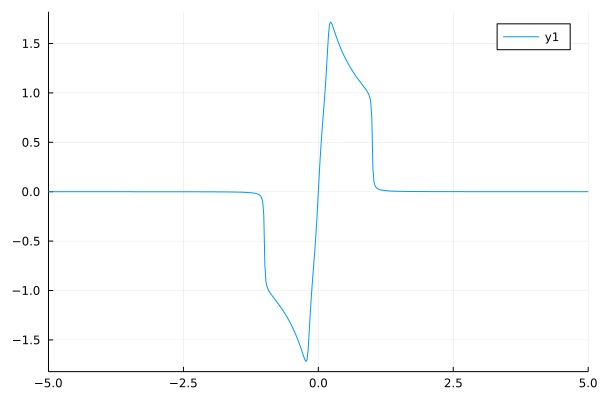

In [32]:
plot(xlim = [-5,5])
plot!(real.(exa_freq), imag.(exa_chi))

In [33]:
exa_chis = exa_chi ./ (1.0 .- lat.U*exa_chi)
;

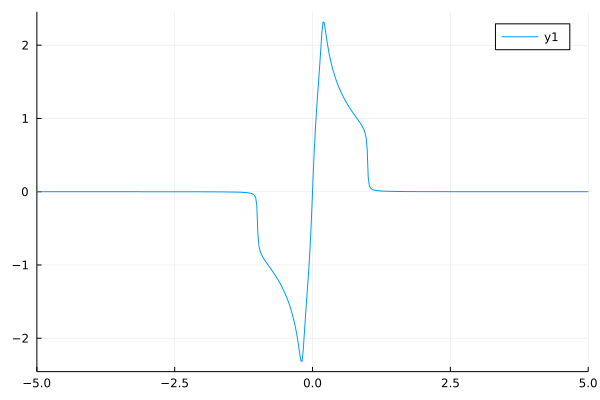

In [34]:
plot(xlim = [-5,5])
plot!(real.(exa_freq), imag.(exa_chis))

In [35]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     8.957702e+01     1.441170e+02
 * time: 0.01747417449951172
     1     7.413112e+01     1.061346e+02
 * time: 3.254526138305664
     2     7.162833e+01     1.001427e+02
 * time: 5.360969066619873
     3     5.917954e+01     5.612636e+01
 * time: 6.202293157577515
     4     5.463513e+01     2.381978e+01
 * time: 7.41197395324707
     5     5.371764e+01     8.605740e-01
 * time: 8.653069019317627
     6     5.371442e+01     9.209819e-02
 * time: 12.268707990646362
     7     5.371440e+01     1.745645e-02
 * time: 13.514626026153564
     8     5.371440e+01     1.341857e-03
 * time: 14.352370023727417
     9     5.371440e+01     1.775663e-04
 * time: 15.591222047805786
    10     5.371440e+01     3.519377e-05
 * time: 16.42086100578308
    11     5.371440e+01     1.995183e-06
 * time: 17.256296157836914
    12     5.371440e+01     3.258201e-07
 * time: 18.70924210548401
    13     5.371440e+01   

In [36]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     5.371440e+01     3.192094e-09
 * time: 0.00019502639770507812
max_theta=0.2879836226012058523342344099815807661505522315100602680288275909872164366220263554959021968895884536509220483751880326457972963363405725754280996840506645
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     5.371440e+01     1.116426e+02
 * time: 0.00021600723266601562
     1     2.746322e+01     9.276157e+01
 * time: 2.2076289653778076
     2     1.891316e+01     1.165128e+02
 * time: 4.266337156295776
     3     1.779620e+01     1.026403e+02
 * time: 9.842339992523193
     4     7.959795e+00     4.870714e+01
 * time: 11.239501953125
     5     5.881854e+00     3.655888e+01
 * time: 13.116173028945923
     6     4.106566e+00     1.685578e+01
 * time: 14.066483974456787
     7     2.529066e+00     1.740717e+01
 * time: 15.06364393234253
     8     1.412738e+00     9.619469e+00
 * time: 17.142174005508423
     9     1.106985

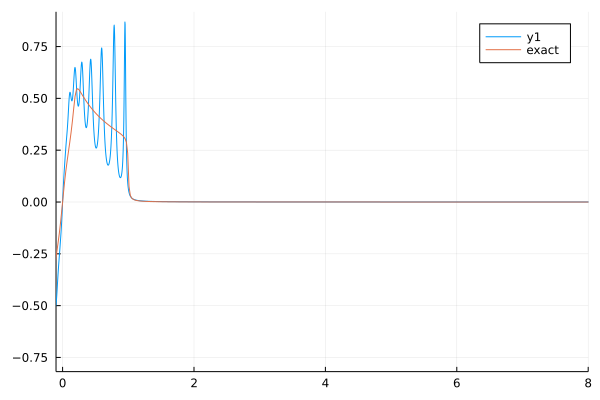

In [37]:
plot(xlim = [-0.1,8])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
#plot!(real.(sol.reals.freq), imag.(sol.reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
plot!(real.(exa_freq), imag.(exa_chi)/pi,label="exact")

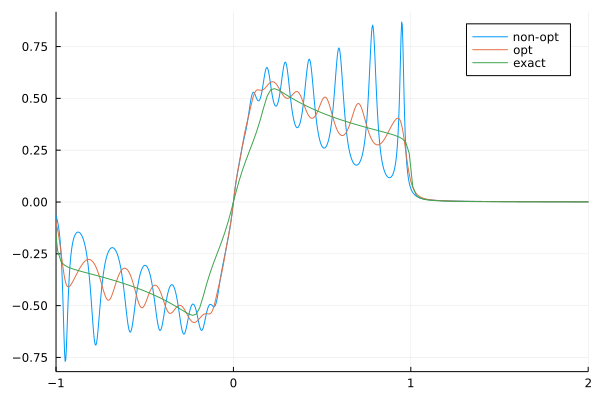

In [38]:
plot(xlim = [-1,2])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt", marker=:+)
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt")
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)),label="opt")
plot!(real.(exa_freq), imag.(exa_chi)/pi,label="exact")

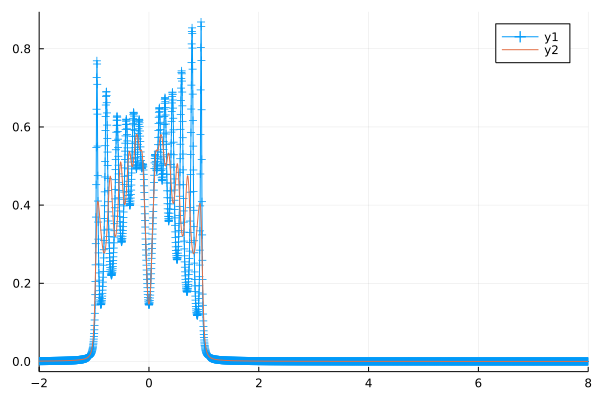

In [39]:
plot(xlim = [-2,8])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi),marker=:+)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)))

In [40]:
ComplexF64.(raw_reals.freq[1])

-10.0 + 0.01im